# Imports

In [16]:
import json
import textwrap
import sqlite3

from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly import io as pio

from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords

from tqdm import tqdm

tqdm.pandas()
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("omw-1.4")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zeinovich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/zeinovich/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/zeinovich/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/zeinovich/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data

In [17]:
# with open("../data/raw/tasks.json", "r") as file:
#     data = json.load(file)

# data = pd.DataFrame.from_dict(data, orient="columns")
# data.head()
db_path = "../artifacts/tasks.db"

conn = sqlite3.connect(db_path)

query = "SELECT * FROM tasks"

data = pd.read_sql(query, conn)
conn.close()

data = data.rename({"task_text": "task"}, axis=1)
data["tags"] = data["tags"].apply(lambda x: json.loads(x)[0])
data["content"] = data["task"].apply(lambda x: x + "\n")
data["content"] = data["content"] + data["options"]

data.head()

,id,guid,task_info,task,options,answer,answer_type,tags,content
0,q7DBD44,030477359D8083EF4F33120D8C7B88D5,i7DBD44,"Укажите варианты ответов, в которых в обоих сл...","недолюбл..вать, завлад..вать\nизменч..вость, в...",,Выбор ответов из предложенных вариантов,[3.7.5 Правописание суффиксов],"Укажите варианты ответов, в которых в обоих сл..."
1,q76BD40,0324D7A39FFB88D24945DE2B468D9A0F,i76BD40,"Определите ряд, в котором в обоих словах пропу...","о..гладил, по..ставка\nпо..черкнуть, о..бой\nп...",,Краткий ответ,[3.7.3 Употребление ъ и ь (в том числе раздел...,"Определите ряд, в котором в обоих словах пропу..."
2,q76164B,0345DDB9DCD884554F38CA7C2A583AA7,i76164B,В одном из приведённых ниже предложений НЕВЕРН...,Природа восхищает нас ВЕЧНОЙ красотой и удивля...,,Краткий ответ,[3.3.3 Основные лексические нормы современног...,В одном из приведённых ниже предложений НЕВЕРН...
3,q7B1D45,038547F8734D9BA54067B2A64262F877,i7B1D45,Расставьте знаки препинания. Укажите предложен...,Сравните строение семян фасоли и перца и выдел...,,Выбор ответов из предложенных вариантов,[3.8.4 Знаки препинания в предложениях с одно...,Расставьте знаки препинания. Укажите предложен...
4,q738248,03FFE67AA360879B42D3DE3622F8B3CE,i738248,В одном из приведённых ниже слов допущена ошиб...,навралА\nозлОбить\nвероисповЕдание\nободренА\n...,,Краткий ответ,[3.2.3 Основные нормы современного литературн...,В одном из приведённых ниже слов допущена ошиб...


# Model

In [18]:
model = SentenceTransformer("sergeyzh/rubert-tiny-turbo")
# model = SentenceTransformer("cointegrated/rubert-tiny2")

# Clusters

## Embeddings

In [19]:
data["etask"] = data["task"].progress_apply(model.encode)
data["eoptions"] = data["options"].progress_apply(model.encode)

  0%|          | 0/1220 [00:00<?, ?it/s]

100%|██████████| 1220/1220 [00:12<00:00, 100.97it/s]


In [20]:
etask = data["etask"].to_numpy()
data["etask"] = data["etask"].apply(np.reshape, args=((1, -1),))
etask = np.vstack(etask)

eoptions = data["eoptions"].to_numpy()
data["eoptions"] = data["eoptions"].apply(np.reshape, args=((1, -1),))
eoptions = np.vstack(eoptions)

etask += 0.1 * eoptions

print(etask.shape, eoptions.shape)

(1220, 312) (1220, 312)


## PCA

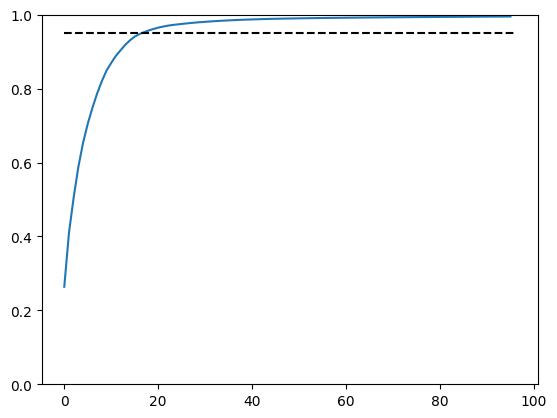

In [21]:
n_comp = 96
pca = PCA(n_components=n_comp)

pca.fit(etask)


plt.plot(np.arange(n_comp), pca.explained_variance_ratio_.cumsum())
plt.plot([0, n_comp], [0.95, 0.95], linestyle="dashed", c="black")
plt.ylim(0, 1)
plt.show()

In [22]:
pca = PCA(n_components=20)
etask = pca.fit_transform(etask)
print(pca.explained_variance_ratio_.sum())

data["etask"] = data["etask"].progress_apply(pca.transform)

0.9613771


100%|██████████| 1220/1220 [00:00<00:00, 18192.41it/s]


## KMeans

### Number of clusters

100%|██████████| 31/31 [00:02<00:00, 15.33it/s]


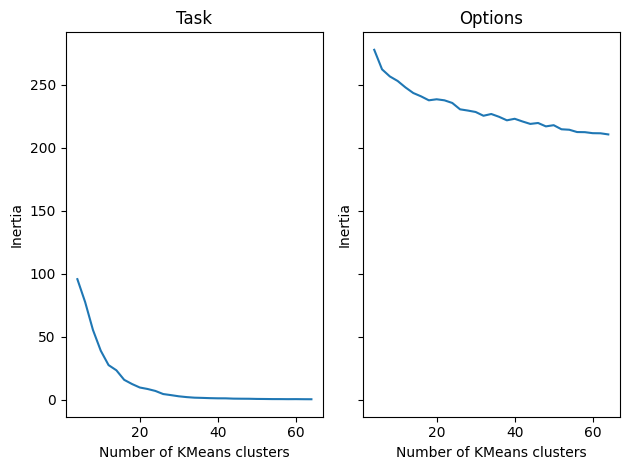

In [23]:
task_ssr = {}

for n_clusters in tqdm(range(4, 65, 2)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(etask)
    task_ssr[n_clusters] = kmeans.inertia_

option_ssr = {}

for n_clusters in tqdm(range(4, 65, 2)):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(eoptions)
    option_ssr[n_clusters] = kmeans.inertia_

fig, ax = plt.subplots(1, 2, layout="tight", sharey=True)
ax[0].plot(task_ssr.keys(), task_ssr.values())
ax[1].plot(option_ssr.keys(), option_ssr.values())

ax[0].set_title("Task")
ax[1].set_title("Options")
ax[0].set_xlabel("Number of KMeans clusters")
ax[1].set_xlabel("Number of KMeans clusters")
ax[0].set_ylabel("Inertia")
ax[1].set_ylabel("Inertia")

plt.show()

### Fit KMeans

In [24]:
N_CLUSTERS = 21
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(etask)

KMeans(n_clusters=21)

In [25]:
data["cluster"] = data["etask"].progress_apply(kmeans.predict)
data["cluster"] = data["cluster"].apply(lambda x: x[0])
data[["id", "cluster"]].to_csv("../data/interim/id_cluster.csv", index=False)

100%|██████████| 1220/1220 [00:00<00:00, 8564.17it/s]


### TFIDF

In [26]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words("russian"),
    max_features=1000,
    ngram_range=(1, 2),
)

# Fit and transform the texts
tfidf_matrix = vectorizer.fit_transform(data["task"])

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()
print(feature_names.shape)

(353,)


In [27]:
def get_top_words(
    cluster_labels, tfidf_matrix, feature_names, num_top_words=8
):
    top_words = {}
    for cluster in np.unique(cluster_labels):
        # Get the indices of texts in the current cluster
        if isinstance(cluster, np.ndarray):
            cluster = cluster[0]
        cluster_indices = np.where(cluster_labels == cluster)[0]

        # Get the TF-IDF matrix for the current cluster
        cluster_tfidf = tfidf_matrix[cluster_indices]

        # Sum the TF-IDF scores for each word in the cluster
        cluster_tfidf_sum = np.sum(cluster_tfidf, axis=0).A1

        # Get the indices of the top words
        top_word_indices = np.argsort(cluster_tfidf_sum)[-num_top_words:]

        # Get the top words
        top_words[int(cluster)] = [feature_names[i] for i in top_word_indices]

    return top_words


# Get top words for each cluster
top_words = get_top_words(data["cluster"], tfidf_matrix, feature_names)

with open("../data/interim/top_words_kmeans.json", "w") as f:
    json.dump(top_words, f, indent=4, ensure_ascii=False)

# Print top words for each cluster
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {words}")

Cluster 0: ['пропущена', 'котором', 'определите', 'пропущенную', 'вставив пропущенную', 'пропущенную букву', 'букву', 'вставив']
Cluster 1: ['ых', 'месте которой', 'цифру месте', 'укажите цифру', 'цифру', 'должна стоять', 'должна', 'стоять запятая']
Cluster 2: ['выделенное слово', 'выделенное', 'пароним', 'ниже предложений', 'ошибку подобрав', 'подобрав выделенному', 'предложений неверно', 'слово']
Cluster 3: ['одна', 'ряда пропущена', 'одна та', 'пропущена одна', 'та буква', 'та', 'буква запишите', 'ответов']
Cluster 4: ['цифры месте', 'цифры', 'укажите цифры', 'месте которых', 'пишется', 'пишется нн', 'нн', 'которых пишется']
Cluster 5: ['скобки выпишите', 'слитно раскройте', 'скобки', 'раскройте скобки', 'раскройте', 'словом пишется', 'словом', 'пишется слитно']
Cluster 6: ['обозначающая ударный', 'ошибка постановке', 'ударения', 'ударения неверно', 'постановке ударения', 'постановке', 'неверно выделена', 'звук выпишите']
Cluster 7: ['позицию второго', 'первого', 'установите', 'уста

## DBSCAN

### Fit DBSCAN

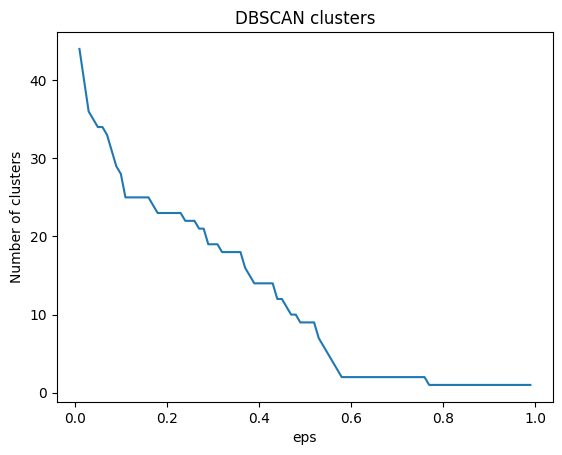

In [28]:
eps_label = ([], [])
for eps in range(1, 100):
    dbscan = DBSCAN(metric="cosine", eps=eps / 100)

    dbscan.fit(etask)
    # print(f"{eps/100:.2f}: Idetified {len(np.unique(dbscan.labels_))} labels")

    eps_label[0].append(eps / 100)
    eps_label[1].append(len(np.unique(dbscan.labels_)))

sns.lineplot(x=eps_label[0], y=eps_label[1])
plt.title("DBSCAN clusters")
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.show()

DBSCAN shows optimal number of clusters of about 23 (at eps in $(0.25, 0.3)$). However, most of datapoints are labeled *outlier*

In [29]:
dbscan = DBSCAN(metric="cosine", eps=0.25)

dbscan.fit(etask)
data["dbscan_labels"] = dbscan.labels_

print(f"Detected {np.max(dbscan.labels_) + 2} labels")

Detected 22 labels


### TF-IDF

In [30]:
top_words = get_top_words(data["dbscan_labels"], tfidf_matrix, feature_names)

# Print top words for each cluster
for cluster, words in top_words.items():
    print(f"Cluster {cluster}: {words}")

Cluster -1: ['месте которыхв', 'месте которых', 'месте которой', 'месте', 'лишнее слово', 'лишнее', 'лицо солдата', 'отредактируйте']
Cluster 0: ['одна', 'ряда пропущена', 'одна та', 'пропущена одна', 'та буква', 'та', 'буква запишите', 'ответов']
Cluster 1: ['пропущенную букву', 'ряд', 'словах пропущена', 'буква выпишите', 'слова вставив', 'ряд котором', 'определите ряд', 'котором обоих']
Cluster 2: ['выделенное слово', 'выделенное', 'пароним', 'ниже предложений', 'ошибку подобрав', 'подобрав выделенному', 'предложений неверно', 'слово']
Cluster 3: ['которых нужно', 'запятую запишите', 'укажите предложения', 'поставить одну', 'одну', 'запятую', 'поставить', 'нужно поставить']
Cluster 4: ['обозначающая ударный', 'ошибка постановке', 'ударения', 'ударения неверно', 'постановке ударения', 'постановке', 'неверно выделена', 'звук выпишите']
Cluster 5: ['позицию второго', 'первого', 'установите', 'установите соответствие', 'позиции первого', 'позицию', 'каждой позиции', 'столбца']
Cluster 6

## Compare

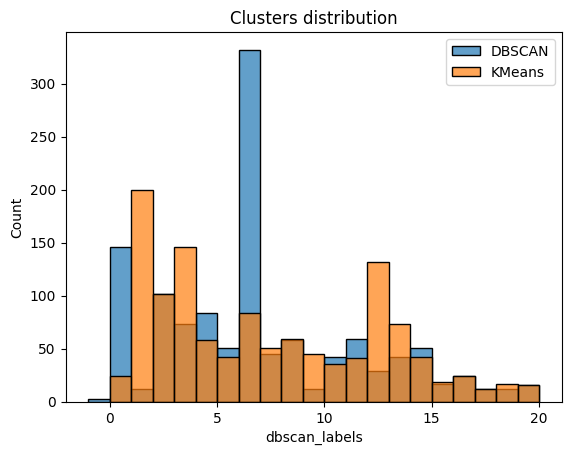

In [31]:
sns.histplot(data, x="dbscan_labels", label="DBSCAN", binwidth=1, alpha=0.7)
sns.histplot(data, x="cluster", label="KMeans", binwidth=1, alpha=0.7)
plt.title("Clusters distribution")
plt.legend()
plt.show()

**KMeans** resembles distribution of `tags` from API which implies that embeddings express data mostly correct

**DBSCAN** labels are very skewed to label 6 

## TSNE

In [32]:
tsne = TSNE()

etask2d = tsne.fit_transform(etask)
np.save("../data/interim/embeddings2d.npy", etask2d)

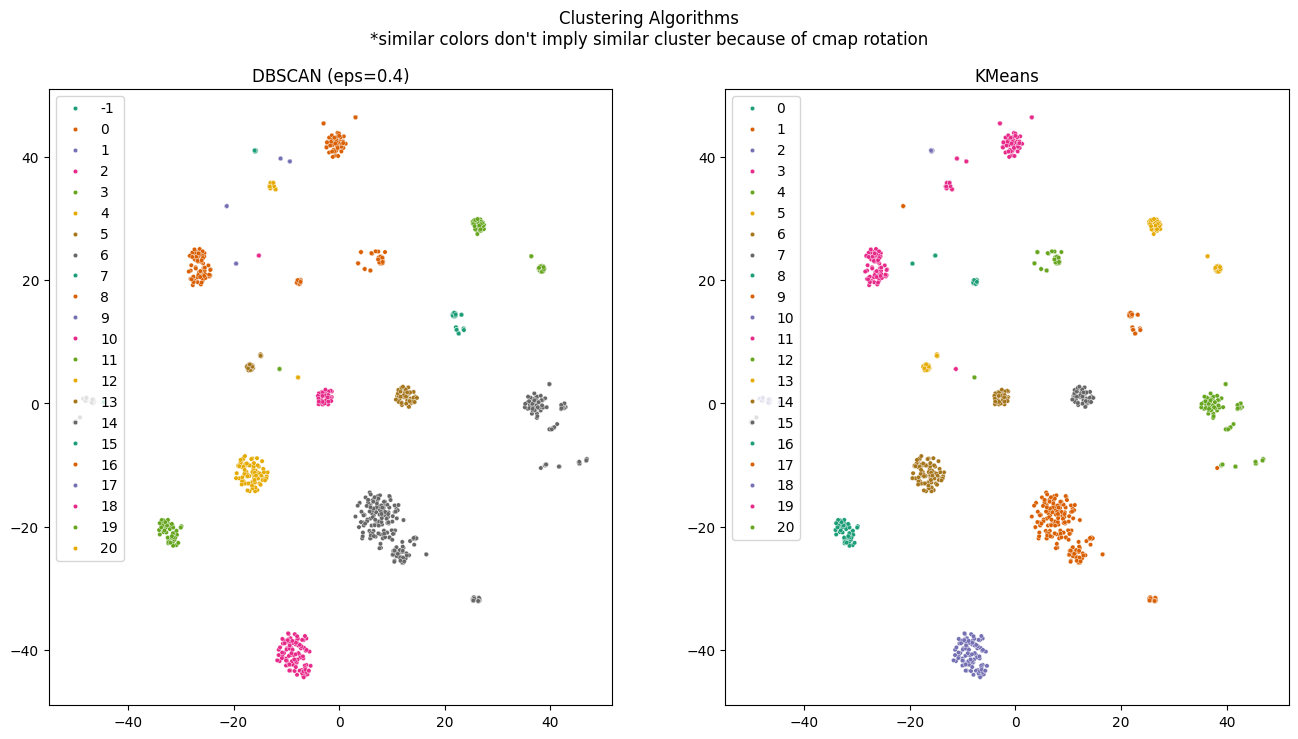

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

sns.scatterplot(
    x=etask2d[:, 0],
    y=etask2d[:, 1],
    s=10,
    hue=data["dbscan_labels"],
    palette="Dark2",
    # legend=False,
    ax=ax[0],
)
sns.scatterplot(
    x=etask2d[:, 0],
    y=etask2d[:, 1],
    s=10,
    hue=data["cluster"],
    palette="Dark2",
    ax=ax[1],
    # legend=False,
)

ax[0].set_title("DBSCAN (eps=0.4)")
ax[1].set_title("KMeans")
ax[0].legend()
ax[1].legend()

fig.suptitle(
    "Clustering Algorithms\n*similar colors don't imply similar cluster because of cmap rotation"
)
plt.show()

### Interactive plot

In [37]:
def wrap_text(text, max_length=50):
    # Replace \n with <br>
    text = text.replace("\n", "<br>")
    # Wrap text at word boundaries
    wrapped_lines = textwrap.wrap(text, width=max_length)
    return "<br>".join(wrapped_lines)


default_colorscale = px.colors.cyclical.IceFire_r
colors = px.colors.sample_colorscale(
    default_colorscale, len(data["cluster"].unique())
)
colors = {i: color for i, color in zip(data["cluster"].unique(), colors)}


# Function to create the interactive plot
def create_interactive_plot(data, embeddings_2d, labels, most_common_words):
    unique_labels = np.unique(labels)
    fig = go.Figure()
    fig.update_layout(width=1000, height=1000)

    # Add cluster centroids
    for label in unique_labels:
        cluster_points = embeddings_2d[labels == label]
        centroid = np.median(cluster_points, axis=0)

        fig.add_trace(
            go.Scatter(
                x=[centroid[0]],
                y=[centroid[1]],
                mode="markers+text",
                text=f"C{label}",
                textposition="top center",
                marker=dict(size=10, color=colors[label], opacity=1),
                textfont=dict(color=colors[label]),
                name=f"C{label}",
            )
        )

        # Add cluster points (initially hidden)
        fig.add_trace(
            go.Scatter(
                x=cluster_points[:, 0],
                y=cluster_points[:, 1],
                mode="markers",
                hovertext=data[labels == label]["content"]
                .apply(wrap_text)
                .tolist(),
                marker=dict(
                    size=5,
                    color=colors[label],
                    opacity=0.2,
                    line=(
                        dict(width=2, color="DarkSlateGrey")
                        if label < 0
                        else None
                    ),
                ),
                name=f"C{label} Points",
                visible=True,  # Initially hidden
                # legend=False,
            )
        )

        # Add most common words (initially hidden)
        words = most_common_words.get(label, [])
        off_xs, off_ys = [], []

        for i, word in enumerate(words):
            angle = 2 * np.pi * i / len(words)
            offset_x = 10 * np.cos(angle)
            offset_y = 10 * np.sin(angle)
            off_xs.append(offset_x)
            off_ys.append(offset_y)

        fig.add_trace(
            go.Scatter(
                x=[centroid[0] + offset_x for offset_x in off_xs],
                y=[centroid[1] + offset_y for offset_y in off_ys],
                mode="text",
                text=words,
                textposition="middle center",
                name=f"C{label} words",
                visible="legendonly",  # Initially hidden
            )
        )

    # Update layout
    fig.update_layout(
        title="Interactive TSNE Cluster Visualization",
        showlegend=True,
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            bgcolor="LightSteelBlue",
            bordercolor="Black",
            borderwidth=2,
        ),
    )

    # Add click event to show/hide cluster points and words
    fig.update_traces(selector=dict(mode="markers+text"))
    fig.show()

    return fig


# Create the interactive plot
fig = create_interactive_plot(data, etask2d, data["cluster"], top_words)
pio.write_html(fig, "../artifacts/clusters_kmeans.html")

## Cluster Impurity

To measure quality of clustering will do impurity test

As "true" labels are tags, will assign clusters to labels and then choose dominant one which will act as "predicted" label and used to calculate classification metrics. In case of multiple tag present, cluster will be assigned to all of them

In [35]:
def assign_clusters_to_tags(data, cluster_col):
    tags = {}

    for _, row in data.iterrows():
        row_tags = row["tags"]
        row_cluster = row[cluster_col]

        for t in row_tags:
            tags[t] = tags.get(t, []) + [row_cluster]

    return {key: tags[key] for key in sorted(tags)}


def get_accuracy(cluster_tags):
    cluster_gt = {}
    cluster_acc = {}

    for t, c_list in cluster_tags.items():
        gt = Counter(c_list).most_common(1)[0][0]
        cluster_gt[t] = gt
        gt_list = [gt] * len(c_list)
        acc = accuracy_score(gt_list, c_list)
        cluster_acc[t[:5]] = acc

    return cluster_acc

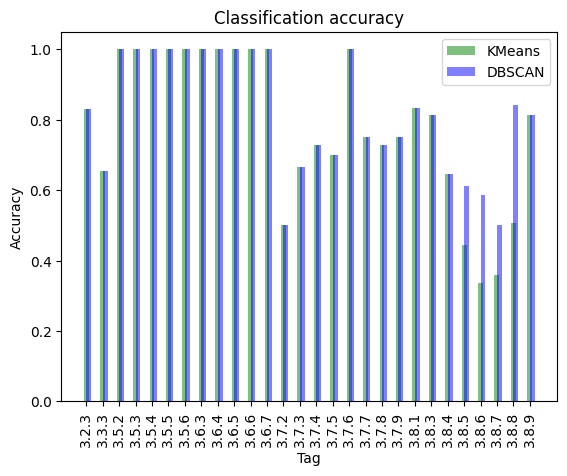

In [36]:
kmeans_tags = assign_clusters_to_tags(data, "cluster")
kmeans_acc = get_accuracy(kmeans_tags)

dbscan_tags = assign_clusters_to_tags(data, "dbscan_labels")
dbscan_acc = get_accuracy(dbscan_tags)

with open("../data/interim/kmeans_acc.json", "w") as f:
    json.dump(kmeans_acc, f, indent=4)

with open("../data/interim/dbscan_acc.json", "w") as f:
    json.dump(dbscan_acc, f, indent=4)

plt.bar(
    kmeans_acc.keys(),
    kmeans_acc.values(),
    align="center",
    width=0.3,
    alpha=0.5,
    color="g",
    label="KMeans",
)
plt.bar(
    dbscan_acc.keys(),
    dbscan_acc.values(),
    align="edge",
    width=0.3,
    alpha=0.5,
    color="b",
    label="DBSCAN",
)
plt.xlabel("Tag")
plt.ylabel("Accuracy")
plt.title("Classification accuracy")
plt.xticks(rotation=90)
plt.legend()
plt.show()

**DBSCAN** shows better accuracy for tags 3.8.5-.8 and similar to **KMeans** otherwise